__Abstract__

- Goal
    - Calibrate Vasicek model for makert Libor and swap rates
- Ref
    - The example is from Section 7.3.1.1 of [Hir13]. 
    - Explicit vasicek pricing is given [here](explicit_vasicek_zcb.ipynb)

__Problem__

All of pricing models require a set of model parameters in order to fully define the dynamics of each model. The process of adjusting model parameters such that the model prices are compatible with market prices is called **Calibration**. 

Input:

- several market LIBOR rates
- several market swap rates

Output:

- Find $\theta = (\alpha, \mu, \sigma, r_t)$ to fit the Vasicek model.

__Anal__


Suppose
- Model prameter $\theta = (\theta_1, ... \theta_m)$ is a vector
- Prices of $n$ instruments are aviable in the market with its market price of $i$th instrument quoted by $C_i$. 
Let's denote $C = (C_1, ..., C_n)$ as a market price vector.
- In theory, $C_i^\theta$ is the model price of the $i$th instrument, and they are denoted as a vector $C^\theta = (C_1^\theta, ...,  C^\theta_n)$. 

Given a distance function $H: \mathbb R^n \times \mathbb R^n \mapsto \mathbb R^+$, calibration is to find the parameter $\theta^*$  which minimize the objective function $H(C^\theta, C)$, i.e.
$$ \theta^* = \arg\min_\theta H(C^\theta, C).$$

Commonly used distance functions for $H$ are 
- $H(x, y) = (\sum_{i=1}^n w_i |x_i - y_i|^p)^{1/p}.$
- $H(x, y) = (\sum_{i=1}^n w_i | \frac{x_i - y_i}{y_i}|^p)^{1/p}.$ If $p = 2$, $w_i =1$, then $H^2$ is called as SSRE (sum of squred relative errors)
- $H(x, y) = (\sum_{i=1}^n w_i |\ln x - \ln y|^p)^{1/p}.$

__Parameters__


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as so

In [2]:

dfLiborRate = pd.DataFrame({'maturity (months)': [1, 2, 3, 6, 12],
                            '20081029 rate(%)': [3.1175, 3.2738, 3.4200, 3.4275, 3.4213],
                            '20110214 rate(%)': [0.2647, 0.2890, 0.3140, 0.4657, 0.7975]
                          })
dfLiborRate

,20081029 rate(%),20110214 rate(%),maturity (months)
0,3.1175,0.2647,1
1,3.2738,0.2890,2
2,3.4200,0.3140,3
3,3.4275,0.4657,6
4,3.4213,0.7975,12


In [3]:
dfSwapRate = pd.DataFrame({'term (year)': [2, 3, 5, 7, 10, 15, 30],
                            '20081029 rate(%)': [2.6967, 3.1557, 3.8111, 4.1497, 4.3638, 4.3753, 4.2772],
                            '20110214 rate(%)': [1.0481, 1.5577, 2.5569, 3.1850, 3.7225, 4.1683, 4.4407]
                          })
dfSwapRate #swap rate s(0, N, 2N), where N is given in the last column; semi-annual payment

,20081029 rate(%),20110214 rate(%),term (year)
0,2.6967,1.0481,2
1,3.1557,1.5577,3
2,3.8111,2.5569,5
3,4.1497,3.1850,7
4,4.3638,3.7225,10
5,4.3753,4.1683,15
6,4.2772,4.4407,30


__Algo__. 


In [4]:
#For Oct 29, 2008 rate 
npLibor = dfLiborRate.values #convert dataframe to ndarray
TT = npLibor[:, -1]/12 #Tenor in year
market_libor = npLibor[:,0]

npSwap = dfSwapRate.values #data from panda dataframe to np.array
NN = npSwap[:,-1] #Number of terms stored in an array
market_swap = npSwap[:, 0]

market_data = np.append(market_libor, market_swap)

In [5]:
from explicit_option_price import *

In [6]:
def model_value(th):
    al, mu, sigma, r0 = th
    LL = [vasicek_libor_rate(T, al, mu, sigma, r0) for T in TT] #calculate Libor
    SS = [vasicek_swap_rate(N, 2*int(N), al, mu, sigma, r0) for N in NN] #calculate swap rate
    return np.append(LL, SS)

In [7]:
#function for SSRE
#x and y shall be np.array with the same length
def SSRE(th):
    x = model_value(th)
    y = market_data
    return np.sum(np.power(x - y, 2)/np.power(y,2))


In [8]:
th0 = [.1, .1, .001, .01]    #initial start
th = so.fmin(SSRE, th0, ftol = .0001, maxiter = 1000)

Optimization terminated successfully.
         Current function value: 0.106657
         Iterations: 117
         Function evaluations: 198


In [13]:
print('---->>>>>For Oct 29, 2008, calibration: ' + str(th))

---->>>>>For Oct 29, 2008, calibration: [0.17164324 0.06705246 0.00144671 0.0019926 ]


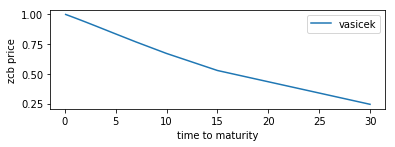

In [10]:
al, mu, sigma, r0 = th
x_co = np.append(TT,NN)
y_co = [vasicek_zcb_value(T, al, mu, sigma, r0) for T in x_co]

plt.subplot(2,1,1)
plt.plot(x_co, y_co, label = 'vasicek')
plt.xlabel('time to maturity')
plt.ylabel('zcb price')
plt.legend()

Text(0.5,0,'time to maturity')

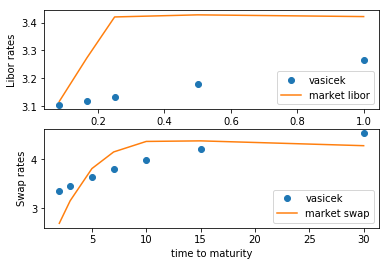

In [11]:
x_co = TT
y_co_1 = [vasicek_libor_rate(T, al, mu, sigma, r0) for T in x_co]
y_co_2 = market_libor

plt.subplot(2,1,1)
plt.plot(x_co, y_co_1, 'o', label = 'vasicek')
plt.plot(x_co, y_co_2, '-', label = 'market libor')
plt.legend()
plt.ylabel('Libor rates')
plt.xlabel('time to maturity')

x_co = NN
y_co_1 = [vasicek_swap_rate(N, 2*int(N), al, mu, sigma, r0) for N in NN]
y_co_2 = market_swap

plt.subplot(2,1,2)
plt.plot(x_co, y_co_1, 'o', label = 'vasicek')
plt.plot(x_co, y_co_2, '-', label = 'market swap')
plt.legend()
plt.ylabel('Swap rates')
plt.xlabel('time to maturity')


__Remark__

- The above calibrations are pretty identical to the reference [Hir13], but not volatility $\sigma$.
- From the curve, calibration does not fit the market data well. This is likely because a single factor model cannot capture the odd shape of market rates prevalent on that date.

In [12]:

#For Feb 14, 2011 rate 
npLibor = dfLiborRate.values #convert dataframe to ndarray
TT = npLibor[:, -1]/12 #Tenor in year
market_libor = npLibor[:,1]

npSwap = dfSwapRate.values #data from panda dataframe to np.array
NN = npSwap[:,-1] #Number of terms stored in an array
market_swap = npSwap[:, 1]

market_data = np.append(market_libor, market_swap)

th0 = [.1, .1, .001, .01]    #initial start

th = so.fmin(SSRE, th0, ftol = .0001, maxiter = 1000)
print('For Feb 14, 2011, calibration: ' + str(th))


Optimization terminated successfully.
         Current function value: 0.072271
         Iterations: 104
         Function evaluations: 183
For Feb 14, 2011, calibration: [0.17164324 0.06705246 0.00144671 0.0019926 ]
